In [1]:
import pandas as pd
import torch
import re
import nltk
import nltk.data
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
# Ensure necessary NLTK resources are available
def download_nltk_resources():
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')

    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')

    try:
        nltk.data.find('sentiment/vader_lexicon')
    except LookupError:
        nltk.download('vader_lexicon')

download_nltk_resources()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\count\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:

# Load the dataset
file_path = "alt_no_mans_sky_steam_review_data_split_reviews_no_index_FULL.csv"
#df = pd.read_csv(file_path, encoding='latin1')
df = pd.read_csv(file_path, encoding='utf-8')

# Check required column
if 'review' not in df.columns:
    raise ValueError("The dataset does not contain a 'review' column")

df = df[['recommendationid', 'review']].dropna().drop_duplicates()


ValueError: The dataset does not contain a 'review' column

Data Preprocessing: Splitting reviews into sentences & cleaning data

In [181]:
# Define stopwords and negations
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

negations = {"not", "never", "none", "no", "don't", "haven't"}
stop_words = stop_words - negations  # Keep negation words
# Add domain-specific words to the stop words list
# stop_words.update(["steam"])

# Function to clean text with stop words (keeping negations)
def clean_text(text, remove_stopwords=True):
    text = re.sub(r"[^a-zA-Z0-9\s’']", "", text.lower().strip())  
    words = word_tokenize(text)
    
    if remove_stopwords:
        words = [word for word in words if word not in stop_words or word in negations]  # Ensure stopwords are removed
    
    return " ".join(words)

# Function to split reviews into unique sentences and keep both versions
def split_into_sentences(row):
    sentences = [s for s in sent_tokenize(str(row["review"])) if re.search(r"[a-zA-Z0-9]", s)]
    if not sentences:
        return [{"recommendationid": row["recommendationid"], "sentence_with_stopwords": "", "sentence_without_stopwords": ""}]

    return [{"recommendationid": row["recommendationid"], 
             "sentence_with_stopwords": clean_text(s, False),
             "sentence_without_stopwords": clean_text(s)} for s in sentences]


# Extract sentences
df_sentences = pd.DataFrame([entry for _, row in df.iterrows() for entry in split_into_sentences(row)]).drop_duplicates()

# Display the first few rows
df_sentences.head(20)

,recommendationid,sentence_with_stopwords,sentence_without_stopwords
0,70427607,this game has the elements of many games sewn ...,game elements many games sewn one incredibly well
1,70427607,a bit of survival fps space sim trading farmin...,bit survival fps space sim trading farming bas...
2,70427607,the result is a beautifully presented journey ...,result beautifully presented journey discovery...
3,70427607,would recommend to everyone who is adventurous,would recommend everyone adventurous
4,70426209,game is k random gen from presets,game k random gen presets
5,70426209,no voice acting,no voice acting
6,70426209,gets old,gets old
7,70426209,but none the less was a swell time,none less swell time
8,70425814,i first played 2 years ago and it was fun for ...,first played 2 years ago fun bit
9,70425814,then i started playing again recently and its ...,started playing recently better


# Save dataset in CSV files

In [182]:
df_sentences.describe()
df_sentences.to_csv('./alt_no_mans_sky_steam_review_data_split_reviews_no_index_FULL.csv', index=False) #Save the dataframe with all the extracted sentences and extra columns 
#df_sentences.to_csv('./split_reviews_no_index.csv', index=False)
#df_sentences.to_csv('./split_reviews_with_index.csv', index=True)
df_sentences_reduced = df_sentences[['recommendationid', 'sentence_with_stopwords', 'sentence_without_stopwords']]
df_sentences_reduced.to_csv('./alt_no_mans_sky_steam_review_data_split_reviews_no_index_reduced_columns.csv', index=False)  # Save reduced dataset

# Save processed data
df_sentences.to_csv("processed_reviews.csv", index=False)

DistilBERT Sentiment Analysis

In [11]:
# Load pre-trained sentiment model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="model_cache")
model = AutoModelForSequenceClassification.from_pretrained(model_name, cache_dir="model_cache")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set model to evaluation mode
model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\count\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\count\game-pulse\model_cache\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [184]:
# Function to apply sentiment prediction in batches
def bert_batch_predict(sentences):
    if not all(isinstance(s, str) for s in sentences):
        raise ValueError("All inputs must be strings")

    inputs = tokenizer(sentences, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    probabilities = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
    return probabilities.tolist(), ["Positive" if p > 0.6 else "Negative" if p < 0.4 else "Neutral" for p in probabilities]

# Remove NaN values and ensure sentences are strings
df_sentences = df_sentences.dropna(subset=["sentence_with_stopwords"])
df_sentences["sentence_with_stopwords"] = df_sentences["sentence_with_stopwords"].astype(str)
df_sentences = df_sentences[df_sentences["sentence_with_stopwords"].str.strip() != ""]  # Remove empty strings

# Convert the column to a NumPy array for efficient slicing
df_sentences_list = df_sentences["sentence_with_stopwords"].values  # Use .values instead of .tolist() for better performance

# Batch processing
batch_size = 32
num_batches = int(np.ceil(len(df_sentences_list) / batch_size))  # Compute the number of batches

# Initialize arrays for efficiency
predicted_scores = np.zeros(len(df_sentences_list))
predicted_labels = np.empty(len(df_sentences_list), dtype=object)
vader_scores = np.zeros(len(df_sentences_list))
vader_labels = np.empty(len(df_sentences_list), dtype=object)

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to compute VADER sentiment
def vader_sentiment(sentence):
    sentiment_score = sia.polarity_scores(sentence)['compound']
    if sentiment_score >= 0.05:
        return sentiment_score, "Positive"
    elif sentiment_score <= -0.05:
        return sentiment_score, "Negative"
    else:
        return sentiment_score, "Neutral"
    

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, len(df_sentences_list))
    batch_sentences = df_sentences_list[start_idx:end_idx].tolist()  # Convert NumPy array to list

    # DistilBERT Sentiment Prediction
    scores, labels = bert_batch_predict(batch_sentences)  # Pass list to function
    predicted_scores[start_idx:end_idx] = scores
    predicted_labels[start_idx:end_idx] = labels

    # VADER Sentiment Prediction
    vader_results = np.array([vader_sentiment(sentence) for sentence in batch_sentences])
    vader_scores[start_idx:end_idx] = vader_results[:, 0]
    vader_labels[start_idx:end_idx] = vader_results[:, 1]

# Assign predictions back to the DataFrame
df_sentences["predicted_score"] = predicted_scores
df_sentences["predicted_label"] = predicted_labels
df_sentences["vader_score"] = vader_scores
df_sentences["vader_label"] = vader_labels

In [185]:
# Save the updated dataset
df_sentences.to_csv("sentiment_predictions.csv", index=False)
print("Sentiment predictions saved successfully!")

Sentiment predictions saved successfully!


Visualization

In [186]:
# Configure Seaborn style for better visuals
sns.set(style="whitegrid")

# Plot sentiment distribution comparison
def plot_sentiment_distribution(df_sentences):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # DistilBERT Sentiment Distribution
    bert_counts = df_sentences["predicted_label"].value_counts()
    bert_colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}
    bert_counts.plot(kind='bar', color=[bert_colors[label] for label in bert_counts.index], ax=axes[0])
    axes[0].set_title("DistilBERT Sentiment Distribution")
    axes[0].set_xlabel("Sentiment")
    axes[0].set_ylabel("Count")
    axes[0].set_xticklabels(bert_counts.index, rotation=0)

    # VADER Sentiment Distribution
    vader_counts = df_sentences["vader_label"].value_counts()
    vader_colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}
    vader_counts.plot(kind='bar', color=[vader_colors[label] for label in vader_counts.index], ax=axes[1])
    axes[1].set_title("VADER Sentiment Distribution")
    axes[1].set_xlabel("Sentiment")
    axes[1].set_ylabel("Count")
    axes[1].set_xticklabels(vader_counts.index, rotation=0)

    plt.tight_layout()
    plt.show()

    # Plot Confusion Matrix
def plot_confusion_matrix(df_sentences):
    labels = ["Positive", "Negative", "Neutral"]
    cm = confusion_matrix(df_sentences["predicted_label"], df_sentences["vader_label"], labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(cmap='Blues', ax=ax)
    plt.title("Confusion Matrix: DistilBERT vs VADER")
    plt.show()

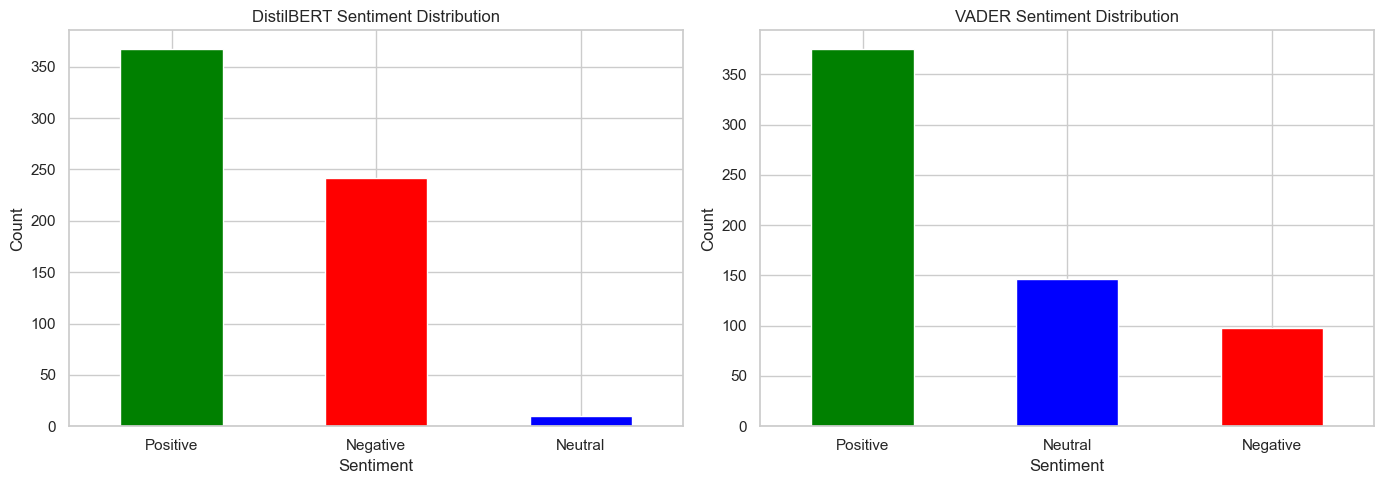

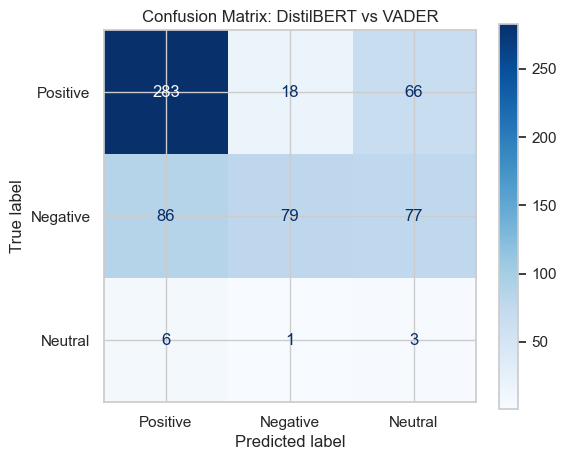

In [187]:

# Generate visualizations
plot_sentiment_distribution(df_sentences)
plot_confusion_matrix(df_sentences)

Explanation
1. Sentiment Distribution Comparison
Two Bar Plots showing the sentiment distribution from DistilBERT and VADER.
Color-coded bars for:
Positive: Green
Negative: Red
Neutral: Blue
2. Confusion Matrix
Displays overlap and differences in sentiment labels predicted by DistilBERT and VADER.
Helps identify:
Where the models agree (diagonal cells).
Where they differ (off-diagonal cells).

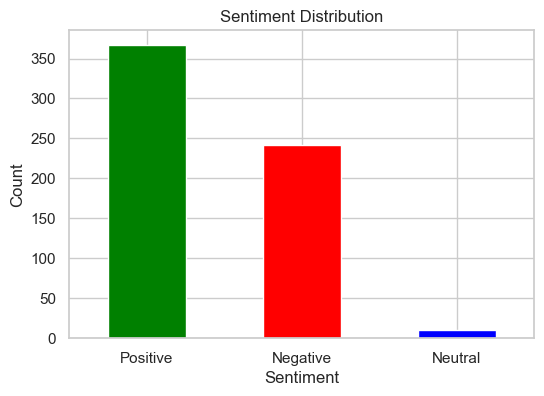

In [188]:
plt.figure(figsize=(6,4))
sentiment_counts = df_sentences["predicted_label"].value_counts()
colors = {"Positive": "green", "Negative": "red", "Neutral": "blue"}  # Add Neutral color
sentiment_counts.plot(kind='bar', color=[colors[label] for label in sentiment_counts.index])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.xticks(rotation=0)
plt.show()

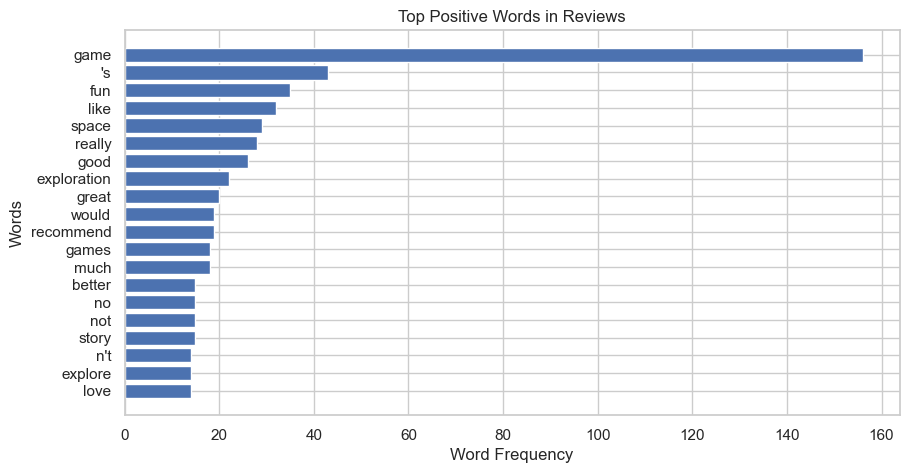

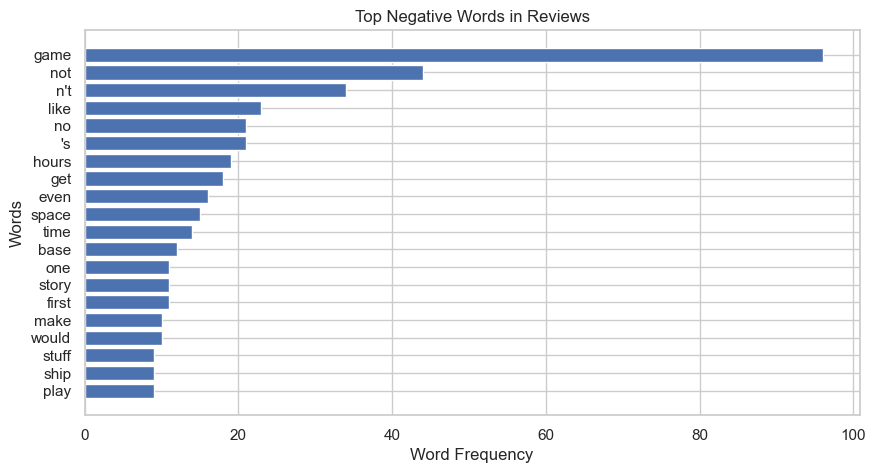

In [189]:
# Top Positive and Negative Words
positive_words = Counter(" ".join(df_sentences[df_sentences["predicted_label"] == "Positive"]["sentence_without_stopwords"]).split()).most_common(20)
negative_words = Counter(" ".join(df_sentences[df_sentences["predicted_label"] == "Negative"]["sentence_without_stopwords"]).split()).most_common(20)

# Function to plot word frequencies
def plot_top_words(word_counts, title):
    words, counts = zip(*reversed(word_counts))  # Extract words and counts for plotting
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts)
    plt.xlabel("Word Frequency")
    plt.ylabel("Words")
    plt.title(title)
    plt.show()

# Plot positive and negative words
plot_top_words(positive_words, "Top Positive Words in Reviews")
plot_top_words(negative_words, "Top Negative Words in Reviews")